# West Nile Virus in Chicago: Model Tuning and Conclusion
---

## Content
---

- [Locations](../code/99_Locations.ipynb)
- [Data Cleaning Summary](../code/01_Data_Cleaning.ipynb) 
- [Train-test Investigation](../code/01a_Train_Test_Investigation.ipynb) 
- [Weather Investigation](../code/01b_Weather_Investigation.ipynb) 
- [Spray Investigation](../code/01c_Spray_Investigation.ipynb) 
- [Feature Engineering](../code/02a_Feature_Engineering.ipynb) 
- [Combined EDA and Preprocessing](../code/02b_Combined_EDA_and_Preprocessing.ipynb) 
- [Model Tuning & Conclusion](../code/03_Model_Tuning_&_Conclusion.ipynb) **Current Notebook**

## Import Library
---

In [1]:
!pip install xgboost==1.3.1

You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn import svm
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,\
                            BaggingClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, plot_roc_curve,\
                            roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
from xgboost import XGBClassifier

import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
import pickle

## Import datasets

In [3]:
train = pd.read_csv('../assets/train_final_v2_daylight.csv')
train.shape

(7370, 55)

In [4]:
train.head(3)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7370 entries, 0 to 7369
Data columns (total 55 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Latitude                        7370 non-null   float64
 1   Longitude                       7370 non-null   float64
 2   WnvPresent                      7370 non-null   int64  
 3   species_culex_erraticus         7370 non-null   int64  
 4   species_culex_pipiens           7370 non-null   int64  
 5   species_culex_pipiens_restuans  7370 non-null   int64  
 6   species_culex_restuans          7370 non-null   int64  
 7   species_culex_salinarius        7370 non-null   int64  
 8   species_culex_tarsalis          7370 non-null   int64  
 9   species_culex_territans         7370 non-null   int64  
 10  species_unspecified_culex       7370 non-null   int64  
 11  month_of_year                   7370 non-null   int64  
 12  week_of_year                    73

In [6]:
X = train.loc[:,[c for c in train.columns if c != 'WnvPresent']]
y = train.loc[:,'WnvPresent']
print(X.shape)
print(y.shape)

## Define Baseline Model
---

In [7]:
train.loc[:, 'WnvPresent'].value_counts(normalize=True)

0    0.946133
1    0.053867
Name: WnvPresent, dtype: float64

We define baseline model as naively predicting for the majority class for every instance of observation. Hence, with reference to our train dataset class proportions, our baseline accuracy would be 94.61%.

## Function for Modeling
---

In [8]:
# Instiantiate models
models = {'lr': LogisticRegression(random_state=42),
          'knn': KNeighborsClassifier(),
          'dt': DecisionTreeClassifier(random_state=42),
          'bag': BaggingClassifier(random_state=42),
          'rf': RandomForestClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'et': ExtraTreesClassifier(random_state=42),
          'ada': AdaBoostClassifier(random_state=42),
          'svc': SVC(random_state=42),
          'xgb': xgb.XGBClassifier(random_state=42)}

In [9]:
# Create list to store model testing results
eval_list = []

## Train-Test Split
---

In [10]:
#Train-Test-Split Function
def process(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, 
                                                        test_size=0.25, stratify=y)
    
    ss = StandardScaler()
    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)
    return ss, X_train_sc, X_test_sc, y_train, y_test


In [11]:
ss, X_train_sc, X_test_sc, y_train, y_test = process(X, y)
print(f'The Shape of X_train_sc: {X_train_sc.shape}')
print(f'The Shape of X_test_sc: {X_test_sc.shape}')
print(f'The Shape of y_train: {y_train.shape}')
print(f'The Shape of y_test: {y_test.shape}')

The Shape of X_train_sc: (5527, 54)
The Shape of X_test_sc: (1843, 54)
The Shape of y_train: (5527,)
The Shape of y_test: (1843,)


In [12]:
# Function to run model
def run_model(model_name, mod, mod_params={}, grid_search=False, smote_flag=False):
    
    results = {}
    results['model'] = model_name
    
    # SMOTE
    if smote_flag:
        sm = SMOTE()
        X_train_smote, y_train_smote = sm.fit_sample(X_train_sc, y_train)

        if grid_search:
            gs = GridSearchCV(mod, param_grid = {**mod_params}, cv=5, verbose=1, n_jobs=-1)
            gs.fit(X_train_smote, y_train_smote)
            mod = gs
            results['params'] = gs.best_params_
            
        else:
            mod.fit(X_train_smote, y_train_smote)
            results['params'] = 'Default'
        
        # Retrieve metrics
        results['train'] = mod.score(X_train_smote, y_train_smote)
        results['test'] = mod.score(X_test_sc, y_test)
        predictions = mod.predict(X_test_sc)
        results['roc'] = roc_auc_score(y_test, predictions)
        results['specificity'] = precision_score(y_test, predictions)
        results['sensitivity'] = recall_score(y_test, predictions)
        results['f_score'] = f1_score(y_test, predictions)
        eval_list.append(results)
        display(results)

        print('### METRICS ###')
        tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Positives: {tp}")

        ########## Ploting the Confusion Matrix and ROC-AUC Curve ##########
        sns.set_style("white")
        fig, ax = plt.subplots(1,2,figsize=(14,5))

        ax = ax.ravel()
        ax[0].set_title('Confusion Matrix',fontsize=18)
        plot_confusion_matrix(mod, X_test_sc, y_test, cmap='Blues', values_format='d',ax=ax[0]);

        ax[1].set_title('ROC-AUC Curve',fontsize=18)
        plot_roc_curve(mod, X_test_sc, y_test,ax=ax[1]);
    
    else: # non-smote
        if grid_search:
            gs = GridSearchCV(mod, param_grid = {**mod_params}, cv=5, verbose=1, n_jobs=-1)
            gs.fit(X_train_sc, y_train_sc)
            mod = gs
            results['params'] = gs.best_params_
            
        else:
            mod.fit(X_train_sc, y_train_sc)
            results['params'] = 'Default'
        
        # Retrieve metrics
        results['train'] = mod.score(X_train_sc, y_train_sc)
        results['test'] = mod.score(X_test_sc, y_test)
        predictions = mod.predict(X_test_sc)
        results['roc'] = roc_auc_score(y_test, predictions)
        results['specificity'] = precision_score(y_test, predictions)
        results['sensitivity'] = recall_score(y_test, predictions)
        results['f_score'] = f1_score(y_test, predictions)
        eval_list.append(results)
        display(results)
        
        print('### METRICS ###')
        tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"True Positives: {tp}")

        ########## Ploting the Confusion Matrix and ROC-AUC Curve ##########
        sns.set_style("white")
        fig, ax = plt.subplots(1,2,figsize=(14,5))

        ax = ax.ravel()
        ax[0].set_title('Confusion Matrix',fontsize=20)
        plot_confusion_matrix(mod, X_test_sc, y_test, cmap='Blues', values_format='d',ax=ax[0]);

        ax[1].set_title('ROC-AUC Curve',fontsize=20)
        plot_roc_curve(mod, X_test_sc, y_test,ax=ax[1]);
        
    return mod

## Model Benchmark
---

To create a Benchmark against a model to check if the function is operating as intended.

The Benchmark will first test against an imbalanced dataset and SMOTE to balance to compare the result against a model(Logistic Regression). These results will be compared against the result obtained from the run_mod function to check its accuracy.

#### Model Benchmark (Logistic Regression w/o SMOTE)
---

Logistic Regression is a classifier that assigns observations consisting of one or more features to a discrete set of classes. It resembles Linear Regression, but takes a step further in transforming its output using the logistic sigmoid function to return a probability value.

In [13]:
# Train-test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, 
                                                    test_size=0.25, stratify=y)

In [14]:
#Standard Scaler
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [15]:
print(f'The Shape of X_train_sc: {X_train_sc.shape}')
print(f'The Shape of X_test_sc: {X_test_sc.shape}')
print(f'The Shape of y_train: {y_train.shape}')
print(f'The Shape of y_test: {y_test.shape}')

The Shape of X_train_sc: (5527, 54)
The Shape of X_test_sc: (1843, 54)
The Shape of y_train: (5527,)
The Shape of y_test: (1843,)


The train score is 0.9460828659308848
The test score is 0.9457406402604449
The roc_auc score is 0.4997133027522936
The specificity/precision score is 0.0
The sensitivity/recall score is 0.0
The f1 score is 0.0
True Negatives: 1743
False Positives: 1
False Negatives: 99
True Positives: 0


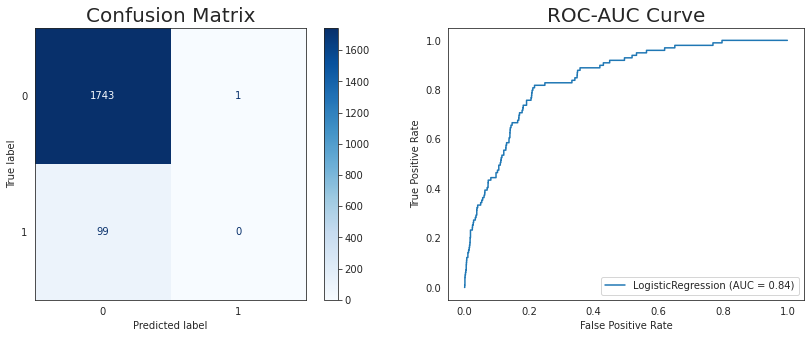

In [16]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_sc, y_train)
print(f'The train score is {lr.score(X_train_sc, y_train)}')
print(f'The test score is {lr.score(X_test_sc, y_test)}')
pred = lr.predict(X_test_sc)
print(f'The roc_auc score is {roc_auc_score(y_test, pred)}')
print(f'The specificity/precision score is {precision_score(y_test, pred)}')
print(f'The sensitivity/recall score is {recall_score(y_test, pred)}')
print(f'The f1 score is {f1_score(y_test, pred)}')

tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

########## Ploting the Confusion Matrix and ROC-AUC Curve ##########
sns.set_style("white")
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax = ax.ravel()
ax[0].set_title('Confusion Matrix',fontsize=20)
plot_confusion_matrix(lr, X_test_sc, y_test, cmap='Blues', values_format='d',ax=ax[0]);

ax[1].set_title('ROC-AUC Curve',fontsize=20)
plot_roc_curve(lr, X_test_sc, y_test,ax=ax[1]);

#### Model Benchmark (Logistic Regression w SMOTE)
---

Classification using class-imbalanced dataset is biased in favor of the majority class. For this project, we have over 7000 WNV-absent observations, but only close to 400 WNV-present ones.  The presence of imbalanced classes has negative impact on the model fitting process, and usually create classifiers that have poor predictive accuracy for the minority class and that tend to classify most new samples into the majority class. As such, we can rely on Synthetic Minority Oversampling TEchnique (SMOTE) as a means to oversample the the positive class (WNV-present) that we are attempting to predict for.

In [17]:
#SMOTE as sample is imbalanced
sm = SMOTE()
X_train_smote, y_train_smote = sm.fit_sample(X_train_sc, y_train)

The train score is 0.7644865174985657
The test score is 0.733043950081389
The roc_auc score is 0.7779602214808637
The specificity/precision score is 0.14721723518850988
The sensitivity/recall score is 0.8282828282828283
The f1 score is 0.25
True Negatives: 1269
False Positives: 475
False Negatives: 17
True Positives: 82


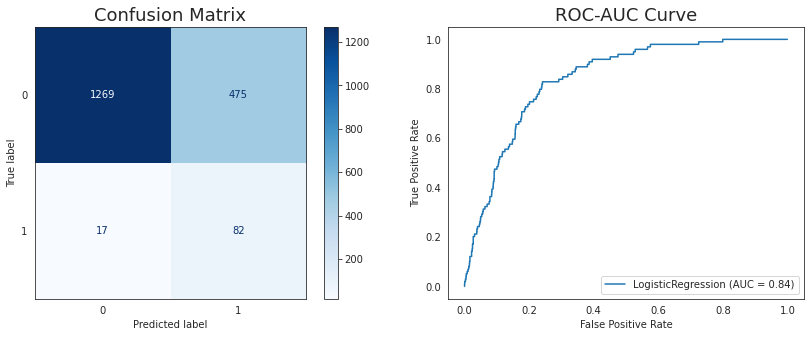

In [18]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_smote, y_train_smote)
print(f'The train score is {lr.score(X_train_smote, y_train_smote)}')
print(f'The test score is {lr.score(X_test_sc, y_test)}')
pred = lr.predict(X_test_sc)
print(f'The roc_auc score is {roc_auc_score(y_test, pred)}')
print(f'The specificity/precision score is {precision_score(y_test, pred)}')
print(f'The sensitivity/recall score is {recall_score(y_test, pred)}')
print(f'The f1 score is {f1_score(y_test, pred)}')

tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

########## Ploting the Confusion Matrix and ROC-AUC Curve ##########
sns.set_style("white")
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax = ax.ravel()
ax[0].set_title('Confusion Matrix',fontsize=18)
plot_confusion_matrix(lr, X_test_sc, y_test, cmap='Blues', values_format='d',ax=ax[0]);

ax[1].set_title('ROC-AUC Curve',fontsize=18)
plot_roc_curve(lr, X_test_sc, y_test,ax=ax[1]);

{'model': 'Logistic Regression',
 'params': 'Default',
 'train': 0.7614266590170204,
 'test': 0.7357569180683667,
 'roc': 0.7793937077193958,
 'specificity': 0.14855072463768115,
 'sensitivity': 0.8282828282828283,
 'f_score': 0.2519201228878648}

### METRICS ###
True Negatives: 1274
False Positives: 470
False Negatives: 17
True Positives: 82


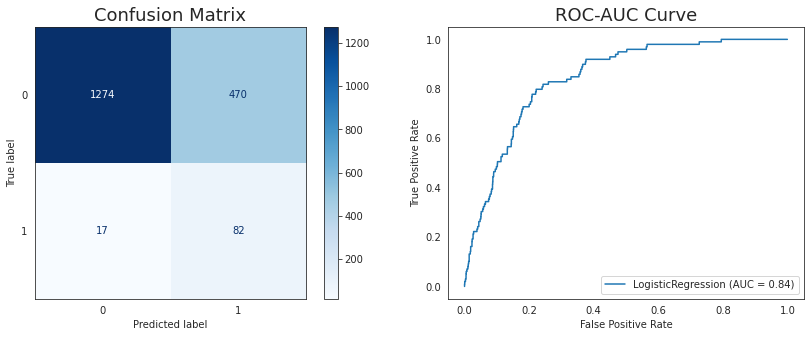

In [19]:
trained_lr = run_model('Logistic Regression', models['lr'], smote_flag=True)

## Model Tuning
---

### Input hyperparameters for Models

In [20]:
# Logistic Regression Model Tuning Hyperparameters
lr_params = {
    'max_iter': [1000, 2500, 5000],
    
    # Trying different types of regularization
    'solver': ['lbfgs', 'liblinear'],
    'penalty':['l2','l1'],
    
     # Trying different alphas of: 10, 1, 0.1 (C = 1/alpha)
    'C':[0.1, 1, 10],
    #'l1_ratio': [0.1, 0.5, 1.0]
}

In [21]:
# KNN Model Tuning Hyperparameters
knn_params = {
    'n_neighbors': range(1, 51, 10),
    'p': [1, 2],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [22]:
# Decision Tree Model Tuning Hyperparameters
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# Source: https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680

dt_params = {
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [20, 40, 50],
    'min_samples_leaf': [5, 10, 20, 30], 
    'ccp_alpha': [0, 0.1, 1, 10]
}

In [23]:
# Bagging Tree Model Tuning Hyperparameters
bag_params = {
    'n_estimators': [50, 125, 200],
    'max_features': [50, 100, 200, 300],
    'n_jobs': [-1]
}

In [24]:
# Gradient Boosting Model Tuning Hyperparameters
# Source: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

gb_params = {
    'learning_rate': [0.1, 0.5, 0.9],
    'n_estimators': [50, 60, 70],
    'max_depth': [3, 5, 7],
    'max_features': [10, 30, 50],
    'min_samples_split': [20, 40, 50],
    'min_samples_leaf': [5, 10, 20, 30]
}

In [25]:
# Extra Tree Model Tuning Hyperparameters
# source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html

et_params = {
    'n_estimators': [50, 125, 200], 
    'max_depth': [3, 5, 7],
    'max_features': [50, 100, 200, 300],
    'min_samples_split': [20, 40, 50],
    'min_samples_leaf': [5, 10, 20, 30],
    'n_jobs': [-1]
}

In [26]:
# Random Forest Model Tuning Hyperparameters
# source: https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/
# source: https://builtin.com/data-science/random-forest-algorithm

rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7],
    'max_features': [10, 30, 50],
    'min_samples_split': [1000, 1500, 2000],
    'min_samples_leaf':[30,50,60],
    'n_jobs': [-1]
}

In [27]:
# ada Boost Model Tuning Hyperparameters
# source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

ada_params = {
    'n_estimators': [40, 50, 60, 100],
    'learning_rate': [0.1, 0.9, 1]
}

In [28]:
# SVC Model Tuning Hyperparameters
# source: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html'

svc_params = {
    'C':[0.1, 1, 10],
    'gamma':[0.01, 0.1, 0.3], 
    'kernel':['linear','rbf']
}

In [29]:
# XG Boost Model Tuning Hyperparameters
# Source: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

xgb_params = {
    'learning_rate': [0.1, 0.9, 1.0],
    'n_estimators' : [100, 300, 500],
    'max_depth' :  [3, 5, 7]
}

### Running model with hyperparameters and GridSearch Enabled
---

In [ ]:
ss, X_train_sc, X_test_sc, y_train, y_test = process(X, y)

#### Logistic Regression (SMOTE and GridSearch enabled)
---

Logistic regression is a statistical method for predicting binary classes. The outcome or target variable is dichotomous in nature. Dichotomous means there are only two possible classes. It computes the probability of an event occurrence. In this instance, we're using it to detect the presence of the WNV. 

It is a special case of linear regression where the target variable is categorical in nature. It uses a log of odds as the dependent variable. Logistic Regression predicts the probability of occurrence of a binary event utilizing a logit function.

The type of logistic regression that is created for this project is the **binary logistic regression** where the target variable has only 2 possible outcomes WNV present or no WNV present.

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.9min finished


{'model': 'Logistic Regression',
 'params': {'C': 10, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'},
 'train': 0.7642952763434692,
 'test': 0.7314161692892024,
 'roc': 0.7723363219349458,
 'specificity': 0.14516129032258066,
 'sensitivity': 0.8181818181818182,
 'f_score': 0.24657534246575347}

### METRICS ###
True Negatives: 1267
False Positives: 477
False Negatives: 18
True Positives: 81


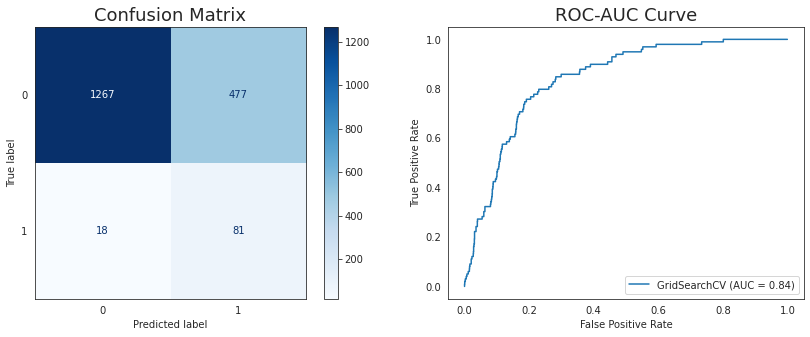

In [30]:
trained_lr_sm = run_model('Logistic Regression', models['lr'], lr_params, True, True)

#### KNearestNeighbors (SMOTE and Gridsearch Enabled)
---

 The K Nearest Neighbors (KNN) model is commonly used for classification problems. It uses feature similarity to predict the class of new data points, in this case WNV present or not present, using 'K' nearest neighbors of each point. While KNN is one of the more simpler and intuitive models, it generally does not perform well on imbalanced data. As such, it is important to use techniques like SMOTE to ensure that results are not skewed towards the majority class.

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.4min finished


{'model': 'KNN',
 'params': {'metric': 'euclidean',
  'n_neighbors': 1,
  'p': 1,
  'weights': 'uniform'},
 'train': 0.9942627653471027,
 'test': 0.8724905046120456,
 'roc': 0.5848681771846909,
 'specificity': 0.13829787234042554,
 'sensitivity': 0.26262626262626265,
 'f_score': 0.18118466898954705}

### METRICS ###
True Negatives: 1582
False Positives: 162
False Negatives: 73
True Positives: 26


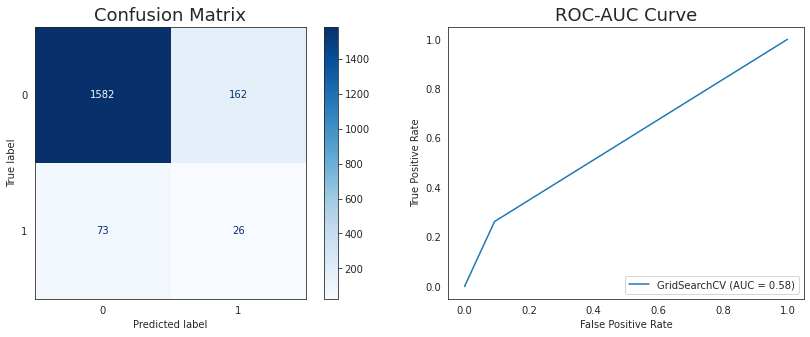

In [ ]:
trained_knn_sm = run_model('KNN', models['knn'], knn_params, True, True)

#### Decision Tree Classifer (SMOTE and Gridsearch Enabled)
---

Decision Tree (DT) is known for its robustness to noise, tolerance against missing information, handling of irrelevant, redundant predictive attribute values, low computational cost, interpretability, fast run time and robust predictors.

The Nodes with the DT are split based on impurity. Impurity is a measure of the homogeneity of the labels on a node. There are many ways to implement the impurity measure, two of which scikit-learn has implemented is the Information gain and **Gini Impurity** or Gini Index.
In a decision tree each internal node represents a 'test' on an attribute (e.g. whether a coin flip comes up heads or tails), each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes). A node that has no children is a leaf.

Information gain uses the entropy measure as the impurity measure and splits a node such that it gives the most amount of information gain. Whereas Gini Impurity measures the divergences between the probability distributions of the target attribute’s values and splits a node such that it gives the least amount of impurity.


$$
\begin{eqnarray*}
\text{Gini impurity} &=& 1 - \sum_{i=1}^{classes} P(\text{class i})^2 \\
\text{Gini impurity (2 classes)} &=& 1 - P(\text{class 1})^2 - P(\text{class 2})^2 \\
text{Gini impurity (3 classes)} &=& 1 - P(\text{class 1})^2 - P(\text{class 2})^2 - P(\text{class 3})^2 \\
\end{eqnarray*}
$$


Limtation of DT: <br>

1. Decision trees can very easily overfit due to variance

2. Decision trees are locally optimal.

3. Decision trees don't work well with unbalanced data.

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 318 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 957 out of 960 | elapsed:  1.2min remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  1.2min finished


{'model': 'DT',
 'params': {'ccp_alpha': 0,
  'max_depth': None,
  'min_samples_leaf': 5,
  'min_samples_split': 20},
 'train': 0.9391853126792886,
 'test': 0.8768312533912099,
 'roc': 0.6014531785747381,
 'specificity': 0.15591397849462366,
 'sensitivity': 0.29292929292929293,
 'f_score': 0.20350877192982458}

### METRICS ###
True Negatives: 1587
False Positives: 157
False Negatives: 70
True Positives: 29


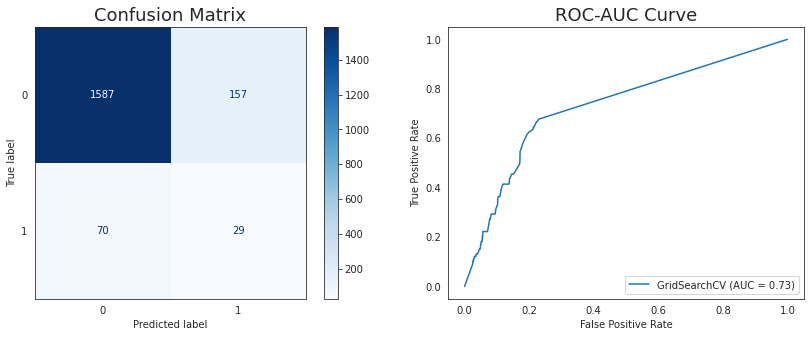

In [ ]:
trained_dt_sm = run_model('DT', models['dt'], dt_params, True, True)

#### Bagging Tree Classifer (SMOTE and Gridsearch Enabled)
---

Part of an Ensemble methods, Bagging Tree Classifier combines several decision trees to produce better predictive performance than utilizing a single decision tree. The main principle behind the ensemble model is that a group of weak learners come together to form a strong learner.

Bagging (Bootstrap Aggregation) is used to reduce the variance of a decision tree by creating several subsets of data from training sample chosen randomly with replacement. Now, each collection of subset data is used to train their decision trees. As a result, we end up with an ensemble of different models. Average of all the predictions from different trees are used which is more robust than a single decision tree.

With bagged decision trees, we generate many different trees on pretty similar data. These trees are strongly correlated with one another. Because these trees are correlated with one another, they will have high variance. Looking at the variance of the average of two random variables  𝑇1  and  𝑇2 :

𝑉𝑎𝑟((𝑇1+𝑇2)/2) = 1/4 * (𝑉𝑎𝑟(𝑇1) + 𝑉𝑎𝑟(𝑇2) + 2𝐶𝑜𝑣(𝑇1,𝑇2))
 
If  𝑇1  and  𝑇2  are highly correlated, then the variance will about as high as we'd see with individual decision trees. By "de-correlating" our trees from one another, we can drastically reduce the variance of our model.

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.5min finished


{'model': 'Bag',
 'params': {'max_features': 50, 'n_estimators': 200, 'n_jobs': -1},
 'train': 0.9942627653471027,
 'test': 0.8969072164948454,
 'roc': 0.5691867065146882,
 'specificity': 0.15267175572519084,
 'sensitivity': 0.20202020202020202,
 'f_score': 0.1739130434782609}

### METRICS ###
True Negatives: 1633
False Positives: 111
False Negatives: 79
True Positives: 20


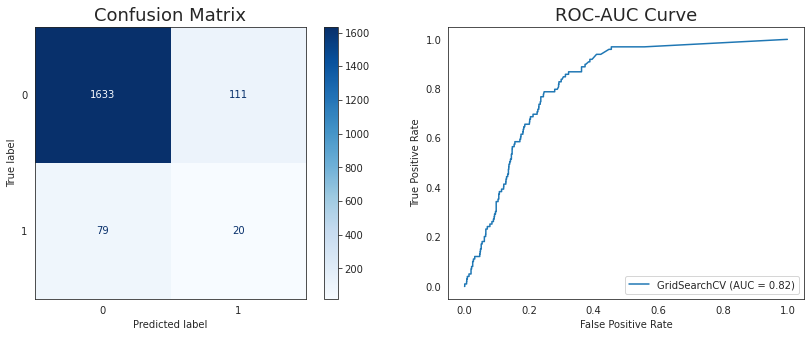

In [ ]:
trained_bag_sm = run_model('Bag', models['bag'], bag_params, True, True)

#### Random Forest Classifer (SMOTE and Gridsearch Enabled)
---

Random Forest is an extension over bagging. It takes one extra step where in addition to taking the random subset of data, it also takes the random selection of features rather than using all features to grow trees.This results in a wide diversity that generally results in a better model.



Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed: 50.0min finished


{'model': 'RF',
 'params': {'max_depth': 7,
  'max_features': 30,
  'min_samples_leaf': 30,
  'min_samples_split': 1000,
  'n_estimators': 200,
  'n_jobs': -1},
 'train': 0.7917383820998278,
 'test': 0.7243624525230602,
 'roc': 0.7829006811231582,
 'specificity': 0.14558058925476602,
 'sensitivity': 0.8484848484848485,
 'f_score': 0.2485207100591716}

### METRICS ###
True Negatives: 1251
False Positives: 493
False Negatives: 15
True Positives: 84


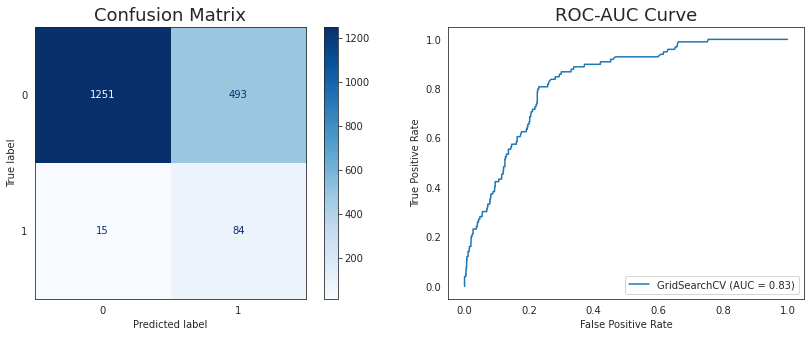

In [ ]:
trained_rf_sm = run_model('RF', models['rf'], rf_params, True, True)

#### Gradient Boosting Classifer (SMOTE and Gridsearch Enabled)
---

Gradient Boosting Classifier typically uses decision trees as base learners, from which an ensemble of such learners will form the final prediction model. 

However, unlike bagging where we build many independent models and combine them using a certain averaging technique, boosting involves building of predictors in a sequential manner where subsequent models learn from the misclassifications (a.k.a errors) of the previous models. Each learner contributes by minimizing the loss function of the whole model via gradient descent method.

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 28.5min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 48.7min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 63.1min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 94.1min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 113.3min
[Parallel(n_jobs=-1)]: Done 4860 out of 4860 | elapsed: 148.1min finished


{'model': 'GB',
 'params': {'learning_rate': 0.5,
  'max_depth': 7,
  'max_features': 50,
  'min_samples_leaf': 5,
  'min_samples_split': 40,
  'n_estimators': 70},
 'train': 0.9934978007267163,
 'test': 0.9202387411828541,
 'roc': 0.5672232647576685,
 'specificity': 0.2073170731707317,
 'sensitivity': 0.1717171717171717,
 'f_score': 0.1878453038674033}

### METRICS ###
True Negatives: 1679
False Positives: 65
False Negatives: 82
True Positives: 17


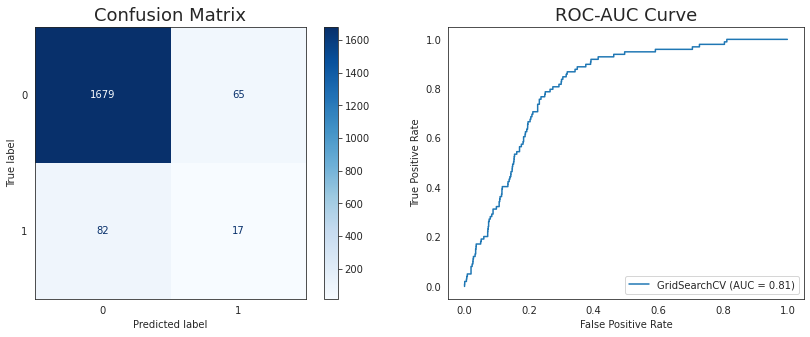

In [ ]:
trained_gb_sm = run_model('GB', models['gb'], gb_params, True, True)

#### Extra Trees Classifer (SMOTE and Gridsearch Enabled)
---

Extra Trees Classifier, similar to ordinary random forests in that they are an ensemble of individual trees, has two main differences: first, each tree is trained using the whole learning sample (rather than a bootstrap sample), and second, the top-down splitting in the tree learner is randomized. 

Instead of computing the locally optimal cut-point for each feature under consideration (based on, e.g., information gain or the Gini impurity), a random cut-point is selected. This value is selected from a uniform distribution within the feature's empirical range (in the tree's training set). Then, of all the randomly generated splits, the split that yields the highest score is chosen to split the node. 

Similar to ordinary random forests, the number of randomly selected features to be considered at each node can be specified. Default values for this parameter are sqrt(p) for classification and p for regression, where p is the number of features in the model.

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 17.2min finished


{'model': 'ET',
 'params': {'max_depth': 7,
  'max_features': 50,
  'min_samples_leaf': 5,
  'min_samples_split': 20,
  'n_estimators': 200,
  'n_jobs': -1},
 'train': 0.8432778733983554,
 'test': 0.7417254476397178,
 'roc': 0.787311185246965,
 'specificity': 0.15285451197053407,
 'sensitivity': 0.8383838383838383,
 'f_score': 0.2585669781931464}

### METRICS ###
True Negatives: 1284
False Positives: 460
False Negatives: 16
True Positives: 83


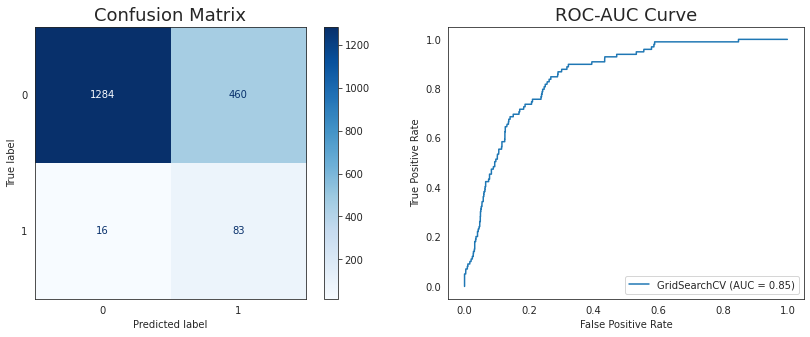

In [ ]:
trained_et_sm = run_model('ET', models['et'], et_params, True, True)

#### AdaBoost Classifer (SMOTE and Gridsearch Enabled)
---

Adaboost also builds an ensemble of weak learners in a sequential manner. At every iteration, it adjusts the weights attached to each instance in the sample distribution by increasing the weights of the misclassified instances and decreasing for correctly predicted ones. After training, the weak learner is added to the ensemble with an associated weight that is contingent on its performance, i.e the better it performs, the more it contributes to the overall prediction outcome.

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   59.5s finished


{'model': 'AdaBoost',
 'params': {'learning_rate': 1, 'n_estimators': 100},
 'train': 0.8647925033467202,
 'test': 0.822571893651655,
 'roc': 0.7585719581132425,
 'specificity': 0.18681318681318682,
 'sensitivity': 0.6868686868686869,
 'f_score': 0.2937365010799136}

### METRICS ###
True Negatives: 1448
False Positives: 296
False Negatives: 31
True Positives: 68


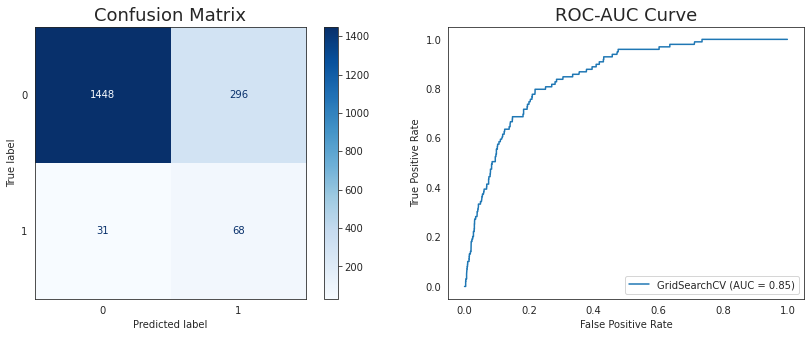

In [ ]:
trained_ada_sm = run_model('AdaBoost', models['ada'], ada_params, True, True)

#### SVC (SMOTE and Gridsearch Enabled)
---

Support Vector Machine (SVM) attempts to find a hyperplane that divides a given dataset into its respective underlying classes. This is done with the use of support vectors (data-points derived from the words), from which the SVM algorithm would establish a hyperplane that generates the greatest margin between it and the support vectors.

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 17.2min finished


{'model': 'SVC',
 'params': {'C': 10, 'gamma': 0.3, 'kernel': 'rbf'},
 'train': 0.9402371390323198,
 'test': 0.8556701030927835,
 'roc': 0.6283824483365767,
 'specificity': 0.15352697095435686,
 'sensitivity': 0.37373737373737376,
 'f_score': 0.2176470588235294}

### METRICS ###
True Negatives: 1540
False Positives: 204
False Negatives: 62
True Positives: 37


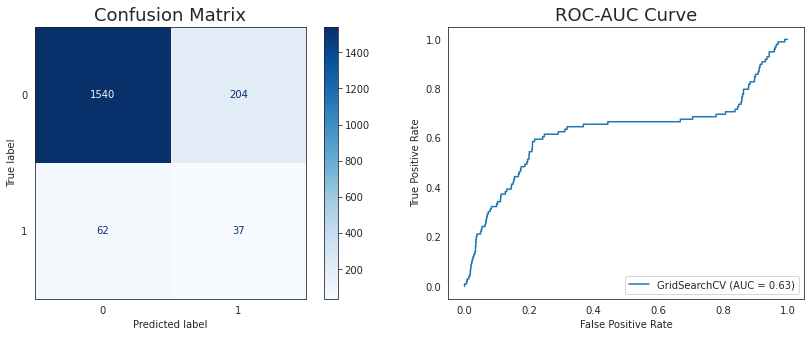

In [ ]:
trained_svc_sm = run_model('SVC', models['svc'], svc_params, True, True)

#### XG Boost Classifer (SMOTE and Gridsearch Enabled)
---

XGBoost stands for Extreme Gradient Boosting, and is a specific implementation of Gradient Boosting with several other features, such as regularization to counteract the inclination to overfit in Gradient Boosting, and built-in capability to handle missing values. 

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 79.6min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 130.0min finished
[09:20:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'model': 'XGB',
 'params': {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500},
 'train': 0.9931153184165232,
 'test': 0.9196961475854585,
 'roc': 0.5574089519043648,
 'specificity': 0.189873417721519,
 'sensitivity': 0.15151515151515152,
 'f_score': 0.16853932584269665}

### METRICS ###
True Negatives: 1680
False Positives: 64
False Negatives: 84
True Positives: 15


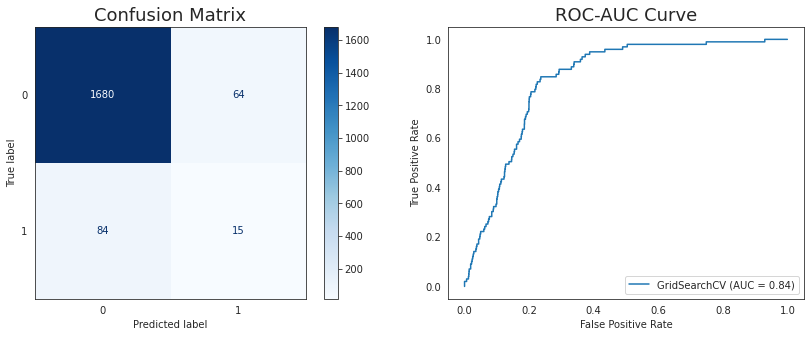

In [31]:
trained_xgb_sm = run_model('XGB', models['xgb'], xgb_params, True, True)

## Save models

At the end of running all the fitting and scoring, we save snapshots of all the trained models for later reference.

In [ ]:
# save log reg
with open('../models/trained_lr_sm.sav','wb') as f:
    pickle.dump(trained_lr_sm, f)

# save knn
with open('../models/trained_knn_sm.sav','wb') as f:
    pickle.dump(trained_knn_sm, f)

# save decision tree
with open('../models/trained_dt_sm.sav','wb') as f:
    pickle.dump(trained_dt_sm, f)

# save bagged trees
with open('../models/trained_bag_sm.sav','wb') as f:
    pickle.dump(trained_bag_sm, f)

# save random forest
with open('../models/trained_rf_sm.sav','wb') as f:
    pickle.dump(trained_rf_sm, f)

# save gradient boost
with open('../models/trained_gb_sm.sav','wb') as f:
    pickle.dump(trained_gb_sm, f)

# save extra trees
with open('../models/trained_et_sm.sav','wb') as f:
    pickle.dump(trained_et_sm, f)

# save adaboost
with open('../models/trained_ada_sm.sav','wb') as f:
    pickle.dump(trained_ada_sm, f)

# save SVC
with open('../models/trained_svc_sm.sav','wb') as f:
    pickle.dump(trained_svc_sm, f)

# save XGBoost
with open('../models/trained_xgb_sm.sav','wb') as f:
    pickle.dump(trained_xgb_sm, f)

## Model Evaluation
---

In [ ]:
# Turning Evaluated List into a DataFrame
eval_df = pd.DataFrame(eval_list)
eval_df.to_csv('../assets/eval_df1.csv', index=False)

In [ ]:
model_result = pd.read_csv('../assets/eval_df1.csv')
model_result

,model,params,train,test,roc,specificity,sensitivity,f_score
0,Logistic Regression,Default,0.766781,0.733587,0.778247,0.147482,0.828283,0.250382
1,Logistic Regression,"{'C': 10, 'max_iter': 1000, 'penalty': 'l1', '...",0.769937,0.727618,0.775093,0.144621,0.828283,0.246246
2,KNN,"{'metric': 'euclidean', 'n_neighbors': 1, 'p':...",0.994263,0.872491,0.584868,0.138298,0.262626,0.181185
3,DT,"{'ccp_alpha': 0, 'max_depth': None, 'min_sampl...",0.939185,0.876831,0.601453,0.155914,0.292929,0.203509
4,Bag,"{'max_features': 50, 'n_estimators': 200, 'n_j...",0.994263,0.896907,0.569187,0.152672,0.202020,0.173913
5,RF,"{'max_depth': 7, 'max_features': 30, 'min_samp...",0.791738,0.724362,0.782901,0.145581,0.848485,0.248521
6,GB,"{'learning_rate': 0.5, 'max_depth': 7, 'max_fe...",0.993498,0.920239,0.567223,0.207317,0.171717,0.187845
7,ET,"{'max_depth': 7, 'max_features': 50, 'min_samp...",0.843278,0.741725,0.787311,0.152855,0.838384,0.258567
8,AdaBoost,"{'learning_rate': 1, 'n_estimators': 100}",0.864793,0.822572,0.758572,0.186813,0.686869,0.293737
9,Logistic Regression,"{'C': 10, 'max_iter': 1000, 'penalty': 'l1', '...",0.771180,0.734129,0.778534,0.147748,0.828283,0.250765


To evaluate the models, we take a look at the accuracy score for the train and test datasets, the ROC-AUC score, specificity, sensitivity and F1 score for each of the 10 models. 

Although the Gradient Boosting and XG Boost models performed best in terms of accuracy (0.91 and 0.92 respectively), both models had rather low sensitivity scores (0.12 and 0.14 respectively), i.e. they did not do a great job of predicting the positive class (presence of the WNV). 

While accuracy is an important measure, for the purposes of this project we are more keen to optimize the number of false negatives (predicting WNV absent when it is actually present) to ensure that infected mosquitos can be identified accurately and swift action can be taken to curb the spread of the virus. As such, we place greater importance on the sensitivity scores (the number of correct positive predictions divided by the total number of positives). In this regard, Logistic Regression and AdaBoost classifiers come out on top, with sensitivity scores of 0.84 and 0.73 and ROC-AUC scores of 0.78 each. 

Based on the fact that it has the highest sensitivty and ROC-AUC score, we pick Logistic Regression as our production model. However, the trade-off is in the form of lower accuracy scores compared to some other models because of a higher rate of false positive predictions.

## Model Insights
---

Based on the selected model, the top 15 features with highest coeeficient value are shown in the graph below.<br>


#### Extraction of coefficients from Logistic Regression

In [ ]:
coef_list = trained_lr_sm.best_estimator_.coef_[0]
features = [col for col in X.columns]
coefficient_df = pd.DataFrame({'Feature': features, 'Coefficient_Value': coef_list})
coefficient_df.sort_values('Coefficient_Value', ascending=False, inplace=True)
coefficient_df = coefficient_df.reindex(coefficient_df.loc[:,'Coefficient_Value'].abs().sort_values(ascending=False).index)
coefficient_df.reset_index(drop=True, inplace=True)
coefficient_df.head(15)

,Feature,Coefficient_Value
0,week_of_year,7.680706
1,WetBulb,6.778655
2,daylight_duration_in_minutes,5.766573
3,DewPoint,-5.072823
4,Cool_mean_past7day,-3.802669
5,Tavg_mean_past7day,3.393275
6,WetBulb_mean_past14day,1.969457
7,Cool_mean_past14day,-1.849813
8,Heat_mean_past14day,1.669798
9,WetBulb_mean_past7day,1.600836


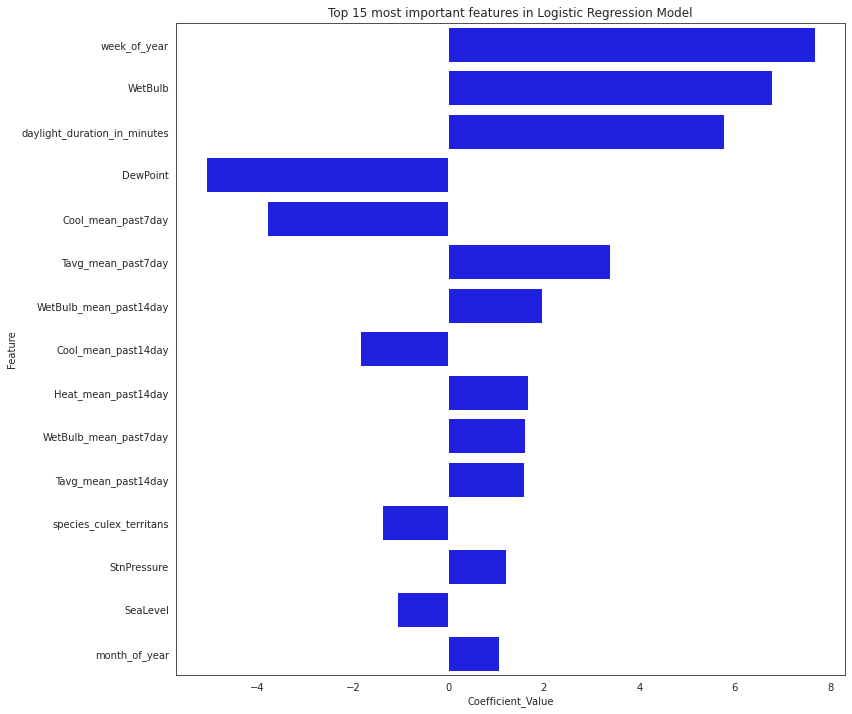

In [ ]:
#coefficient_df.plot(color='Blue', kind='barh', figsize=(12, 12))
plt.figure(figsize=(12, 12))
plt.title('Top 15 most important features in Logistic Regression Model')
sns.barplot(data=coefficient_df.head(15), x='Coefficient_Value', y='Feature', color='Blue')
plt.show();

**Insights**<br>
The above bar plot shows the top 15 features that influence prediction outcomes in the Logistic Regression model. Week of Year had the strongest coefficient value. Other time-centric features like month_of_year also tended to influence the outcome of WNV occurrence.

WetBulb had the second strongest coefficient value. The positive value indicated that a high wet bulb temperature would contribute to the likelihood of a trap being classified as WNV-positive. Other weather-centric features, particularly the historical weather features such as WetBulb_mean_past7day, Tavg_mean_past14day and Tavg_mean_past7day also featured in the top 15 features. Again, their positive values indicate that a continuous period of high temperature tend to higher occurrences of WNV.

Culex Territans species has a negative coefficient, mostly owing to the fact that it is not one of the carrier species of WNV, thus presence of this species in an observation would lower the likelihood of WNV prediction.

Interestingly, dew point has a strong negative coefficient, seemingly indicating that lower humidity leads to higher likelihood of WNV occurrence. The earlier EDA phase revealed inconsistent trends when monthly mean dew point was plotted against mosquito-count and WNV-occurrence. Based on this coefficient analysis, perhaps historical dew point feature may shed more like as to whether a cetain level of humidity in a preceeding period could have an impact on WNV occurrence.

**Limitation**<br>
There are a few limitation to the production model. The model is not the most ideal in terms of specificity as it is ranked 6th among the ten models that were produced. This is due to the higher False Positives detected in the model based on the confusion matrix. As False Positives means a prediction of WNR but in actual fact there isn't present of WNR, it could lead to vector measures being carried out. This will cause the budget for vector control measures to increase when which may result in higher cost-benefit. <br>
As the spray dataset was dropped, during the EDA process, the production model was built based on inputs from train(trap) and weather dataset. Hence, it is not possible to obtain the true study of cost benefit for the effectiveness of the spray and only measures the trap against certain weather patterns. 

Apart from this instance, the model is limited to usage within Chicago as weather patterns differs within states and even countries. The species of mosquito will also differ from other areas. For example, in singapore, West Nile Virus has least to none importance as compared to the presence of Dengue Fever. 

**Recommendation**<br>
To potentially overcome the limitation, more spray data need to be collected to study the effectiveness of the spray. More data inputs can be obtained for train data set by increasing the frequency of revisit especially during the peak periods of the WNR (emphasis to Jul - Sep). As the two weather stations are approx 20 km apart from each other, their readings were very similar from each other. it will be beneficial if more data can be acquired from different weather stations within Chicago to have an accurate reading in each area of Chicago.

## Submission to Kaggle
---

### Read in Kaggle data

In [ ]:
test_kaggle_original = pd.read_csv('../assets/test_final_v2_daylight.csv')

### Drop Id column and assign to new dataframe

In [ ]:
test_kaggle = test_kaggle_original.drop(columns='Id')

### Inspect Kaggle data

In [ ]:
X_train_sc.shape

(5527, 54)

In [ ]:
test_kaggle.shape

(116293, 54)

In [ ]:
test_kaggle.head()

,Latitude,Longitude,species_culex_erraticus,species_culex_pipiens,species_culex_pipiens_restuans,species_culex_restuans,species_culex_salinarius,species_culex_tarsalis,species_culex_territans,species_unspecified_culex,month_of_year,week_of_year,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,CodeSum_BR,CodeSum_DZ,CodeSum_FG,CodeSum_HZ,CodeSum_RA,CodeSum_TS,CodeSum_TSRA,CodeSum_VCTS,Tavg_mean_past7day,WetBulb_mean_past7day,Heat_mean_past7day,Cool_mean_past7day,AvgSpeed_mean_past7day,PrecipTotal_mean_past7day,CodeSum_RA_sum_past7day,CodeSum_TSRA_sum_past7day,CodeSum_DZ_sum_past7day,Tavg_mean_past14day,WetBulb_mean_past14day,Heat_mean_past14day,Cool_mean_past14day,AvgSpeed_mean_past14day,PrecipTotal_mean_past14day,CodeSum_RA_sum_past14day,CodeSum_TSRA_sum_past14day,CodeSum_DZ_sum_past14day,CodeSum_RA_sum_past21day,CodeSum_TSRA_sum_past21day,CodeSum_DZ_sum_past21day,daylight_duration_in_minutes
0,41.95469,-87.800991,0,0,1,0,0,0,0,0,6,24,74,7,56,64,0,9,0.0,29.28,29.99,8.9,18,10.0,0,0,0,0,0,0,0,0,74.142857,68.142857,0.0,9.142857,12.6,0.304571,5,2,0,69.428571,62.928571,1.0,5.428571,9.95,0.218857,9,5,1,10,7,1,910.0
1,41.95469,-87.800991,0,0,0,1,0,0,0,0,6,24,74,7,56,64,0,9,0.0,29.28,29.99,8.9,18,10.0,0,0,0,0,0,0,0,0,74.142857,68.142857,0.0,9.142857,12.6,0.304571,5,2,0,69.428571,62.928571,1.0,5.428571,9.95,0.218857,9,5,1,10,7,1,910.0
2,41.95469,-87.800991,0,1,0,0,0,0,0,0,6,24,74,7,56,64,0,9,0.0,29.28,29.99,8.9,18,10.0,0,0,0,0,0,0,0,0,74.142857,68.142857,0.0,9.142857,12.6,0.304571,5,2,0,69.428571,62.928571,1.0,5.428571,9.95,0.218857,9,5,1,10,7,1,910.0
3,41.95469,-87.800991,0,0,0,0,1,0,0,0,6,24,74,7,56,64,0,9,0.0,29.28,29.99,8.9,18,10.0,0,0,0,0,0,0,0,0,74.142857,68.142857,0.0,9.142857,12.6,0.304571,5,2,0,69.428571,62.928571,1.0,5.428571,9.95,0.218857,9,5,1,10,7,1,910.0
4,41.95469,-87.800991,0,0,0,0,0,0,1,0,6,24,74,7,56,64,0,9,0.0,29.28,29.99,8.9,18,10.0,0,0,0,0,0,0,0,0,74.142857,68.142857,0.0,9.142857,12.6,0.304571,5,2,0,69.428571,62.928571,1.0,5.428571,9.95,0.218857,9,5,1,10,7,1,910.0


### Adhoc load model for Kaggle scoring

In [ ]:
selected_model = trained_rf_sm

### Transform Kaggle data

In [ ]:
test_kaggle_sc = ss.transform(test_kaggle)

In [ ]:
test_kaggle_sc = pd.DataFrame(test_kaggle_sc, columns=test_kaggle.columns.tolist())
test_kaggle_sc.head()

,Latitude,Longitude,species_culex_erraticus,species_culex_pipiens,species_culex_pipiens_restuans,species_culex_restuans,species_culex_salinarius,species_culex_tarsalis,species_culex_territans,species_unspecified_culex,month_of_year,week_of_year,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,CodeSum_BR,CodeSum_DZ,CodeSum_FG,CodeSum_HZ,CodeSum_RA,CodeSum_TS,CodeSum_TSRA,CodeSum_VCTS,Tavg_mean_past7day,WetBulb_mean_past7day,Heat_mean_past7day,Cool_mean_past7day,AvgSpeed_mean_past7day,PrecipTotal_mean_past7day,CodeSum_RA_sum_past7day,CodeSum_TSRA_sum_past7day,CodeSum_DZ_sum_past7day,Tavg_mean_past14day,WetBulb_mean_past14day,Heat_mean_past14day,Cool_mean_past14day,AvgSpeed_mean_past14day,PrecipTotal_mean_past14day,CodeSum_RA_sum_past14day,CodeSum_TSRA_sum_past14day,CodeSum_DZ_sum_past14day,CodeSum_RA_sum_past21day,CodeSum_TSRA_sum_past21day,CodeSum_DZ_sum_past21day,daylight_duration_in_minutes
0,0.92815,-1.227595,-0.013452,-0.538096,1.094356,-0.633817,-0.093599,-0.023304,-0.158231,0.0,-1.517439,-1.621456,0.172239,0.705453,-0.403779,-0.064436,-0.35032,0.058996,-0.413813,-0.149402,0.274966,1.034023,0.01239,1.009752,-0.650961,-0.119643,-0.111609,-0.342737,-0.623453,-0.336441,-0.442496,-0.213986,0.329519,0.814444,-0.476902,0.254595,4.141989,0.991738,2.187568,0.859473,-0.386561,-0.593643,-0.233297,0.230842,-0.661917,2.180462,0.837803,2.574481,1.554242,0.832739,1.722785,1.567567,0.426139,1.094683
1,0.92815,-1.227595,-0.013452,-0.538096,-0.913780,1.577741,-0.093599,-0.023304,-0.158231,0.0,-1.517439,-1.621456,0.172239,0.705453,-0.403779,-0.064436,-0.35032,0.058996,-0.413813,-0.149402,0.274966,1.034023,0.01239,1.009752,-0.650961,-0.119643,-0.111609,-0.342737,-0.623453,-0.336441,-0.442496,-0.213986,0.329519,0.814444,-0.476902,0.254595,4.141989,0.991738,2.187568,0.859473,-0.386561,-0.593643,-0.233297,0.230842,-0.661917,2.180462,0.837803,2.574481,1.554242,0.832739,1.722785,1.567567,0.426139,1.094683
2,0.92815,-1.227595,-0.013452,1.858404,-0.913780,-0.633817,-0.093599,-0.023304,-0.158231,0.0,-1.517439,-1.621456,0.172239,0.705453,-0.403779,-0.064436,-0.35032,0.058996,-0.413813,-0.149402,0.274966,1.034023,0.01239,1.009752,-0.650961,-0.119643,-0.111609,-0.342737,-0.623453,-0.336441,-0.442496,-0.213986,0.329519,0.814444,-0.476902,0.254595,4.141989,0.991738,2.187568,0.859473,-0.386561,-0.593643,-0.233297,0.230842,-0.661917,2.180462,0.837803,2.574481,1.554242,0.832739,1.722785,1.567567,0.426139,1.094683
3,0.92815,-1.227595,-0.013452,-0.538096,-0.913780,-0.633817,10.683905,-0.023304,-0.158231,0.0,-1.517439,-1.621456,0.172239,0.705453,-0.403779,-0.064436,-0.35032,0.058996,-0.413813,-0.149402,0.274966,1.034023,0.01239,1.009752,-0.650961,-0.119643,-0.111609,-0.342737,-0.623453,-0.336441,-0.442496,-0.213986,0.329519,0.814444,-0.476902,0.254595,4.141989,0.991738,2.187568,0.859473,-0.386561,-0.593643,-0.233297,0.230842,-0.661917,2.180462,0.837803,2.574481,1.554242,0.832739,1.722785,1.567567,0.426139,1.094683
4,0.92815,-1.227595,-0.013452,-0.538096,-0.913780,-0.633817,-0.093599,-0.023304,6.319869,0.0,-1.517439,-1.621456,0.172239,0.705453,-0.403779,-0.064436,-0.35032,0.058996,-0.413813,-0.149402,0.274966,1.034023,0.01239,1.009752,-0.650961,-0.119643,-0.111609,-0.342737,-0.623453,-0.336441,-0.442496,-0.213986,0.329519,0.814444,-0.476902,0.254595,4.141989,0.991738,2.187568,0.859473,-0.386561,-0.593643,-0.233297,0.230842,-0.661917,2.180462,0.837803,2.574481,1.554242,0.832739,1.722785,1.567567,0.426139,1.094683


### Perform prediction on Kaggle data

In [ ]:
kaggle = pd.DataFrame()
pred = selected_model.predict(test_kaggle_sc)
kaggle['Id'] = test_kaggle_original['Id']
kaggle['WnvPresent'] = pred

### Inspect predictions

In [ ]:
kaggle.head()

,Id,WnvPresent
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
kaggle.WnvPresent.value_counts()

0    82136
1    34157
Name: WnvPresent, dtype: int64

In [ ]:
kaggle.WnvPresent.value_counts(normalize=True)

0    0.706285
1    0.293715
Name: WnvPresent, dtype: float64

### Save predictions for submission to Kaggle for scoring

In [ ]:
kaggle.to_csv('../assets/kaggle_rf.csv', index=False)

### Final Kaggle Score

Kaggle submission of predictions made by the selected Logistic Regression model yielded the following scores:

<img src='../images/Kaggle_lr_daylight.JPG'>

## Conclusion
---

**Key Findings**
* Periods with warmer temperatures, such as July and August, were found to have high number of mosquitoes and high WNV occurrences.
* Mosquito Count and the WNV occurrence were found to be postively correlated especially during the months from July to August.
* Spray count data was excluded as there was only 5 out of 20 months of trap data with spray in them, hence showing no clear correlation between the number of mosquitoes and the spray count.
* Periods of high temperature and low precipitation are a likely factor in contributing to the rise in WNV occurrences.


**Project Limitations**
* The model is limited to usage within Chicago as weather patterns differs within states, countries as well as the species of mosquitoes.
* Official cost figures of the spray were unavailable.
* The frequency of the spray count is inconsistent, and as a result we cannot further view a trend between the number of mosqutioes and the spray count.
* As the spray data was dropped during the EDA process, only inputs from train, especially the trap, and the weather dataset was used to build the final production model. Hence, the cost benefit effectiveness of the spray cannot be measured as the model only measures against certain weather patterns.

**In conclusion**:

Overall, the model that we've chosen, logisitics regression, has done a decent job in providing us predictive features and it can be used to help the city in identifying potential outbreaks.
As the model has the least False Negatives among the other models, it's more likely to detect the areas with WNV presence in them.
Hence, we've chosen it be our production model to be used in identifying WNV presence.
Should resources permit, we can also do a study on reducing the number of reservoir hosts (dead birds) within the city to effectively kill the source of the WNV.
Combined with vigilant monitoring on the ground and educating the public on the preventation of mosquitoes breeding, we believe that this could significantly decrease the number of 
mosquitoes as well as the West Nile Virus presence.

### Additional Investigation
---

#### 1) Model based on WNR Related Mosquitoes
---

In [ ]:
train = pd.read_csv('../assets/train_final_v2_daylight.csv')
train.shape

In [ ]:
def drop_mosquito_species(df):
    """
    Function to drop mosquitoes that do not have WNV presence in them
    """
    # Function to drop mosquito species
    mos_lst = ['species_culex_erraticus','species_culex_salinarius','species_culex_tarsalis','species_culex_territans','species_unspecified_culex']
    df.drop(mos_lst,axis='columns',inplace=True)
    return df

In [ ]:
X = drop_mosquito_species(train.loc[:,[c for c in train.columns if c != 'WnvPresent']])
y = train.loc[:,'WnvPresent']
print(X.shape)
print(y.shape)

(7370, 49)
(7370,)


In [ ]:
#SMOTE as sample is imbalanced
sm = SMOTE()
X_train_smote, y_train_smote = sm.fit_sample(X_train_sc, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.1min finished


{'model': 'Logistic Regression',
 'params': {'C': 10, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'},
 'train': 0.7769171925798432,
 'test': 0.7352143244709712,
 'roc': 0.7933984338800852,
 'specificity': 0.1520572450805009,
 'sensitivity': 0.8585858585858586,
 'f_score': 0.2583586626139817}

### METRICS ###
True Negatives: 1270
False Positives: 474
False Negatives: 14
True Positives: 85


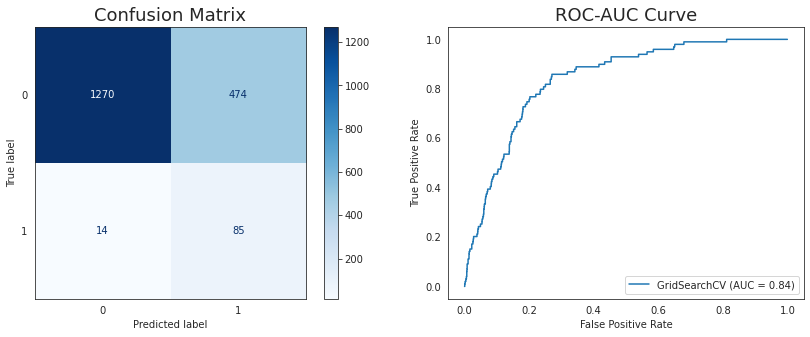

In [ ]:
trained_lr_sm = run_model('Logistic Regression', models['lr'], lr_params, True, True)

Based on the feature experimented with dropping mosquito species that have no WNV presence in them, the model showed little difference in the False Negatives reduction and the AUC ROC curve against the original model. 
It also yielded an almost similar result when posted on the Kaggle website. Hence, this model was discarded in favor of the original model.

#### 2) Model trained on 2007 and 2013 data only
---

As 2007 and 2013 had the highest instance of the WNV, we tried running models trained specifically on data from the two years.

In [ ]:
train_0713 = train.loc[(train['year'] == 2007) | (train['year'] == 2013)]
train_0713.shape

We did not proceed with a model trained only on data from 2007 and 2013. Reason being, the new models did not do as well as the original model run in terms of Sensitivity and ROC-AUC scores, and the models would be less generalizable as they are only trained on data from specific years. 

#### 3) Model based on Clustering
---

Traps within proximity of each other tend to share similar environmental conditions, such as prevailing weather effects or shared ground/water-based conditions. As such, grouping such traps into clusters may lead to discovery of certain area clusters that are more prone to WNV occurrence.

#### Combine latitude and longitude information from both datasets

In [ ]:
train_location_df = train.loc[:,['Latitude','Longitude']]
test_location_df = test_kaggle.loc[:,['Latitude','Longitude']]

all_location_df = pd.concat([train_location_df, test_location_df])
all_location_df.shape

(123663, 2)

#### Perform data scaling

In [ ]:
clustering_ss = StandardScaler()
all_location_df_scaled = clustering_ss.fit_transform(all_location_df)
all_location_df_scaled.shape

#### Perform clustering

We perform K-Means clustering across a few possible n_cluster values, and use silhouette score comparison to derive the most optimal n_cluster setting. For silhouette score is a measure of how similar an observation is to its own cluster (degree of cohesion) compared to other clusters ( degree of separation). It ranges between 1 to -1, and a a score that is closer to 1 indicates  that the object is well matched to its own cluster and poorly matched to neighboring clusters.

In [ ]:
cluster_count = [3, 5, 7, 9, 11]

kmeans_result_dict = {'n_cluster': [], 'sil_score': []}

for c in cluster_count:
    print(c)
    km = KMeans(n_clusters=c, random_state=42).fit(all_location_df_scaled)
    sil_score = silhouette_score(all_location_df_scaled, km.labels_)
    kmeans_result_dict['n_cluster'].append(c)
    kmeans_result_dict['sil_score'].append(sil_score)

kmeans_result_df = pd.DataFrame(kmeans_result_dict)
kmeans_result_df

From the above search, n_cluster value of 7 yielded the best silhouette score of 0.44, so we would perform extract the labels from the K-Means model that is fitted for 7 clusters.

In [ ]:
km_selected = KMeans(n_clusters=7, random_state=42).fit(all_location_df_scaled)
all_location_df.loc[:, 'kmeans_cluster'] = km_selected.labels_

##### One-hot encode and merge cluster information back to datasets

While clusters are assigned numerical values, they are definitely not ordinal in nature, so we perform one-hot-encoding on the new *kmeans_cluster* column.

In [ ]:
all_location_df_dummified = pd.get_dummies(all_location_df.loc[:,'kmeans_cluster'], prefix='kmeans_cluster')

train_location_augmented_df = all_location_df_dummified.iloc[0:7370]
train_with_clusters = pd.concat([train, train_location_augmented_df], axis=1)

test_location_augmented_df = all_location_df_dummified.iloc[7370:]
test_kaggle_with_clusters = pd.concat([test_kaggle, test_location_augmented_df], axis=1)

#### 4) Model (w/o CodeSum)
---

As CodeSum features did not feature in the top predictors, we experimented with running a model without CodeSum features.

In [ ]:
codesum_cols = train_weather_spray.columns[train_weather_spray.columns.str.contains('CodeSum')]

In [ ]:
#Dropping all CodeSum cols from the train data
train_weather_spray_exp5 = train_weather_spray_exp5.drop(columns=codesum_cols , errors='ignore')
train_weather_spray_exp5.info()

In [ ]:
#Dropping all CodeSum cols from the test data
test_exp5 = test_exp5.drop(columns=codesum_cols, errors='ignore')

We did not proceed to drop CodeSum as the Sensitivity and ROC-AUC scores for the model without CodeSum were lower compared to the original modeling run and the new model did not yield significantly better results on Kaggle.